In [1]:
"""
Created on Wed Jan 10 17:13:16 2024
@author: Wu Yuxuan
"""

import os
import warnings

import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns
import numpy as np
from matplotlib import rc_context
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
seed = 123

warnings.simplefilter(action='ignore', category=FutureWarning)
# info
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

-----
anndata     0.10.3
scanpy      0.1.dev3254+g5b9bc72
-----
PIL                         10.1.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        23.2.0
attrs                       23.2.0
babel                       2.14.0
brotli                      1.1.0
certifi                     2024.02.02
cffi                        1.16.0
charset_normalizer          3.3.2
colorama                    0.4.6
comm                        0.1.4
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.8.0
decorator                   5.1.1
defusedxml                  0.7.1
dill                        0.3.7
dot_parser                  NA
executing                   2.0.1
fastjsonschema              NA
fqdn                        NA
gmpy2                       2.1.2
google                      NA
h5py                        3.10.0
idna                       

In [3]:
os.chdir('/home/wu/datb1/reseq_ppp')

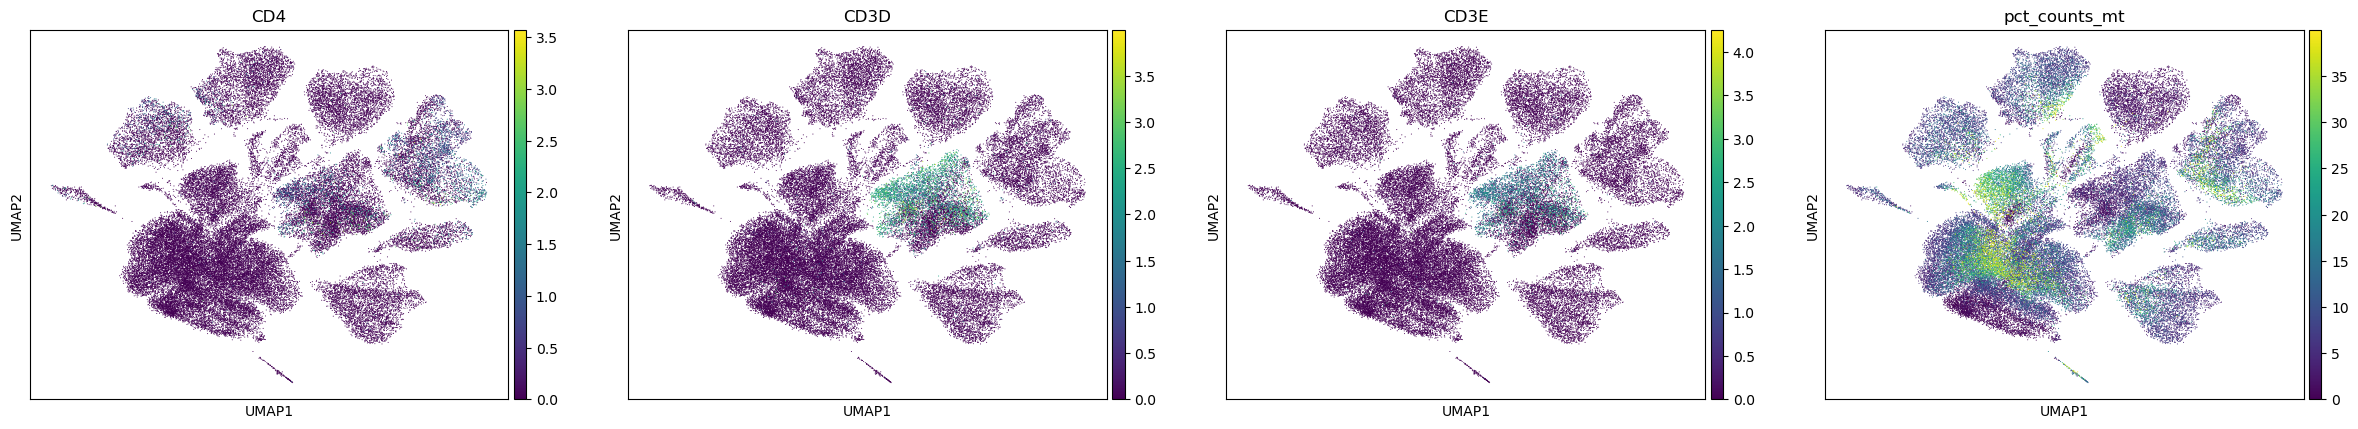

In [4]:
adata_all = ad.read_h5ad('processed_data/ALL_PPP_10X.h5ad')
adata_all_raw = ad.read_h5ad('processed_data/ALL_PPP_10X_raw.h5ad')
sc.pl.umap(adata_all, color=['CD4', 'CD3D', 'CD3E', 'pct_counts_mt'])

/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


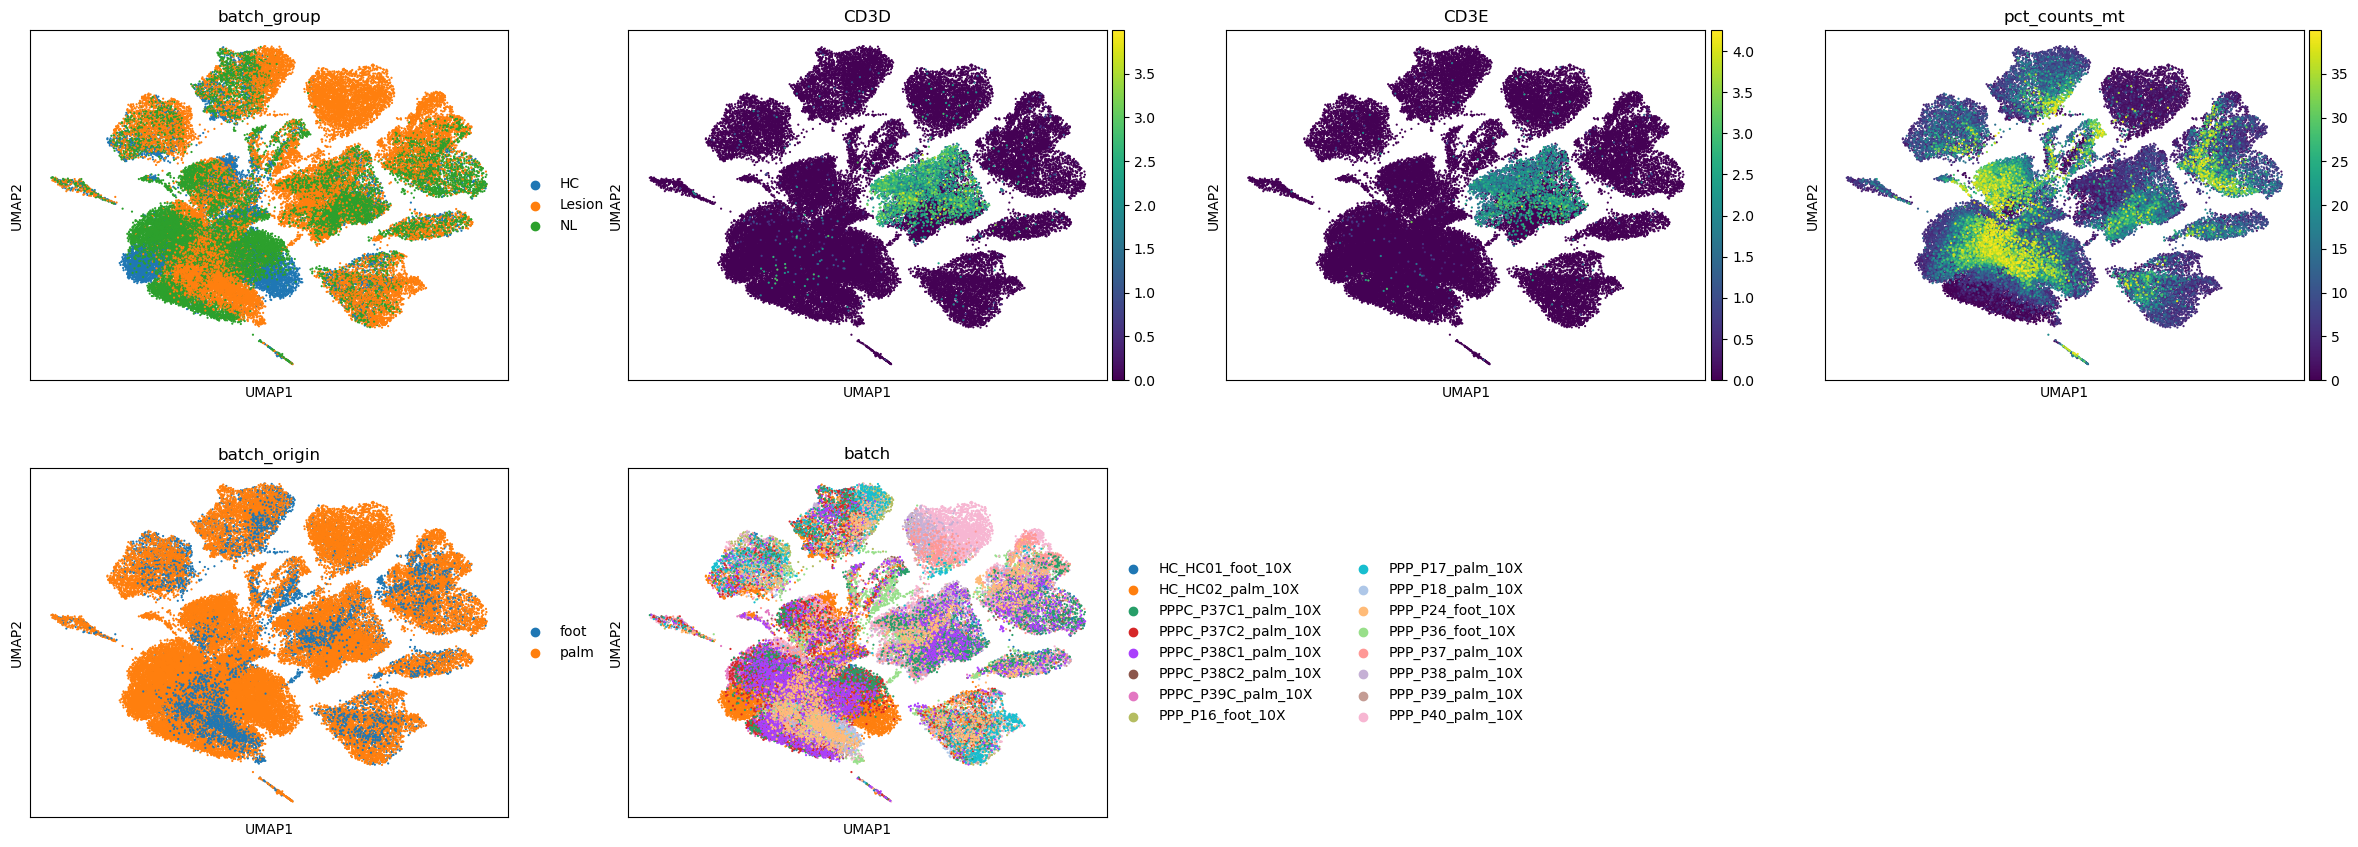

In [5]:
sc.pl.umap(adata_all, color=['batch_group', 'CD3D', 'CD3E', 'pct_counts_mt', 'batch_origin', 'batch'], size=10)

In [6]:
adata_all.obs.leiden.cat.categories

Index(['Eccrine gland cell (EG)', 'Fibroblast (FB)', 'Keratinocyte I',
       'Keratinocyte II', 'Mast cell', 'Melanocyte', 'Myeloid cell', 'Neuron',
       'PPP neutrophil', 'T cell', 'Vascular endothelial cell (VE)',
       'Vascular smooth muscle cell (VSM)'],
      dtype='object')

In [7]:
adata_immu = adata_all.raw.to_adata()[adata_all.obs['leiden'].str.contains('Myeloid|T cell|Mast|neutrophil')].copy()
adata_immu.obs['leiden_rough'] = adata_immu.obs['leiden'].copy()

adata_immu.layers['counts'] = adata_all_raw[adata_all.obs['leiden'].str.contains('Myeloid|T cell|Mast|neutrophil')].X.copy()

In [8]:
adata_immu

AnnData object with n_obs × n_vars = 17284 × 18704
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'batch_origin', 'batch_group', 'Meta', 'Gender', 'Age', 'leiden', 'leiden_rough'
    var: 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'batch', 'batch_colors', 'batch_group_colors', 'batch_origin_colors', 'batch_raw', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

Standardizing Data across genes.

Found 15 batches

Found 0 numerical variables:
	

Found 174 genes with zero variance.
Fitting L/S model and finding priors

Finding parametric adjustments



/home/wu/scanpy/scanpy/preprocessing/_combat.py:340: RuntimeWarning: invalid value encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
/home/wu/scanpy/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


Adjusting data

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:01:09)
extracting highly variable genes


/home/wu/scanpy/scanpy/preprocessing/_highly_variable_genes.py:212: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


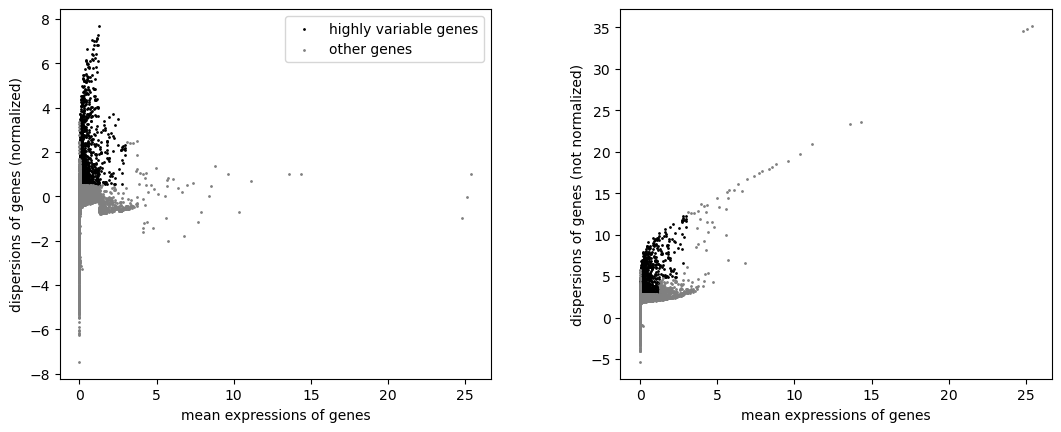

In [9]:
adata_immu.raw = adata_immu.copy()

sc.pp.combat(adata_immu, key='batch')

sc.pp.regress_out(adata_immu, ['total_counts', 'pct_counts_mt'], n_jobs=4, add_intercept=True)

sc.pp.highly_variable_genes(adata_immu, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata_immu)

sc.pp.scale(adata_immu, max_value=10)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:11)


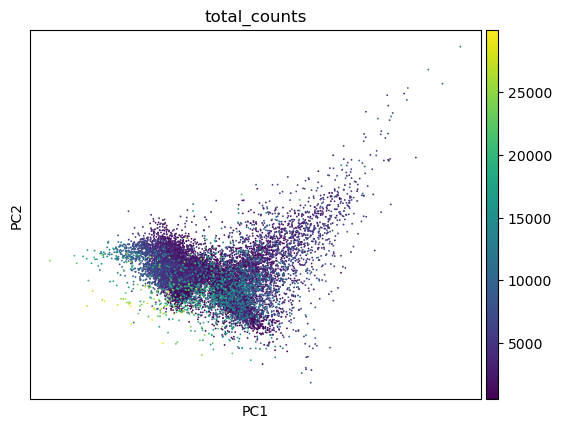

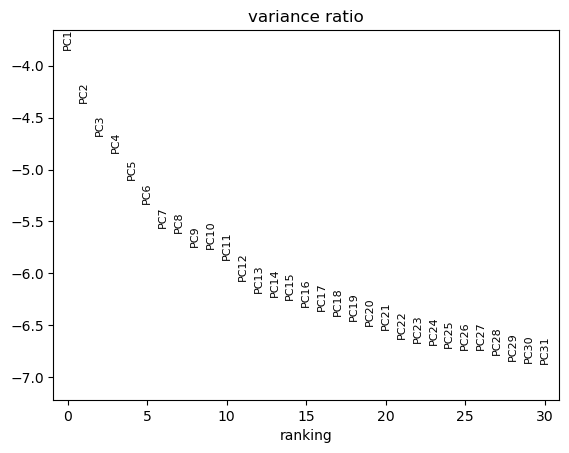

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)


In [10]:
sc.tl.pca(adata_immu, svd_solver='arpack', random_state=seed)
sc.pl.pca(adata_immu, color='total_counts')

sc.pl.pca_variance_ratio(adata_immu, log=True)

sc.pp.neighbors(adata_immu, n_neighbors=15, n_pcs=20, random_state=seed)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


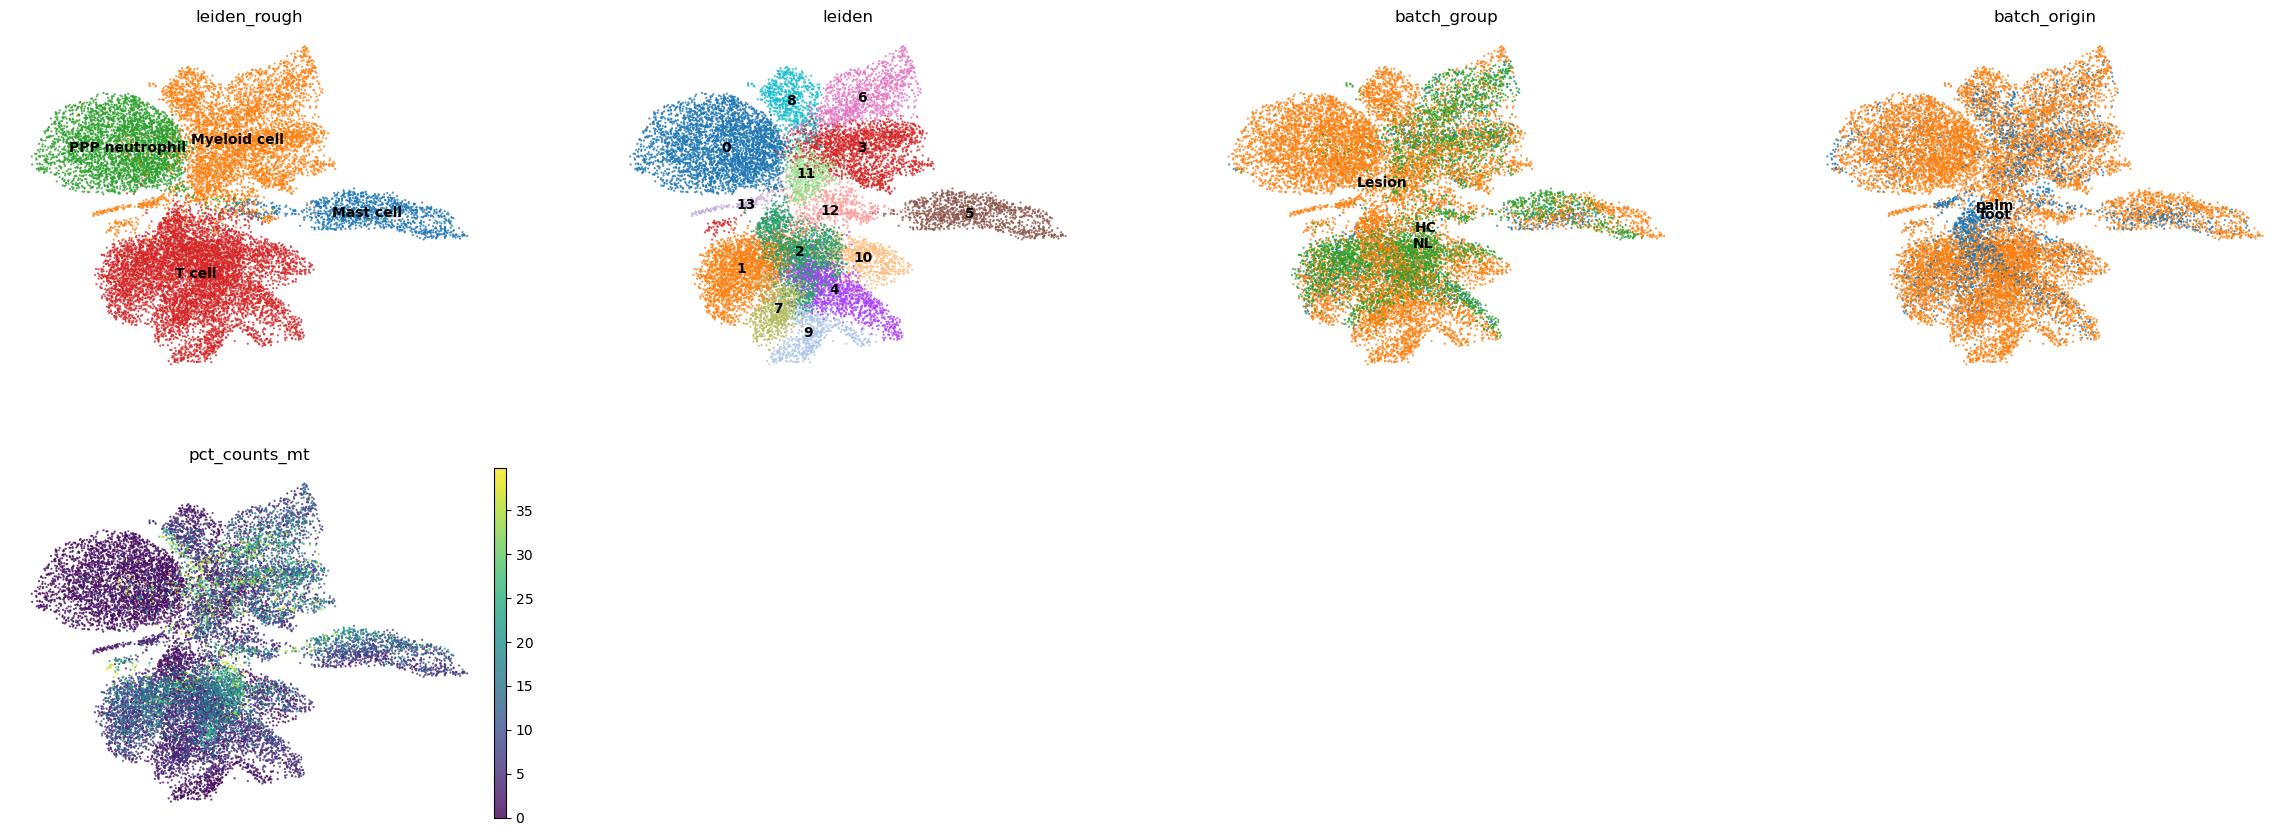

In [11]:
sc.tl.umap(adata_immu, random_state=seed, min_dist=0.5, spread=0.5)
# sc.pl.umap(adata_immu)

sc.tl.leiden(adata_immu, resolution=0.6, random_state=seed)
sc.pl.umap(adata_immu, color=['leiden_rough', 'leiden', 'batch_group', 'batch_origin', 'pct_counts_mt'], frameon=False, legend_loc='on data', size=10, alpha=0.8)

/home/wu/scanpy/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


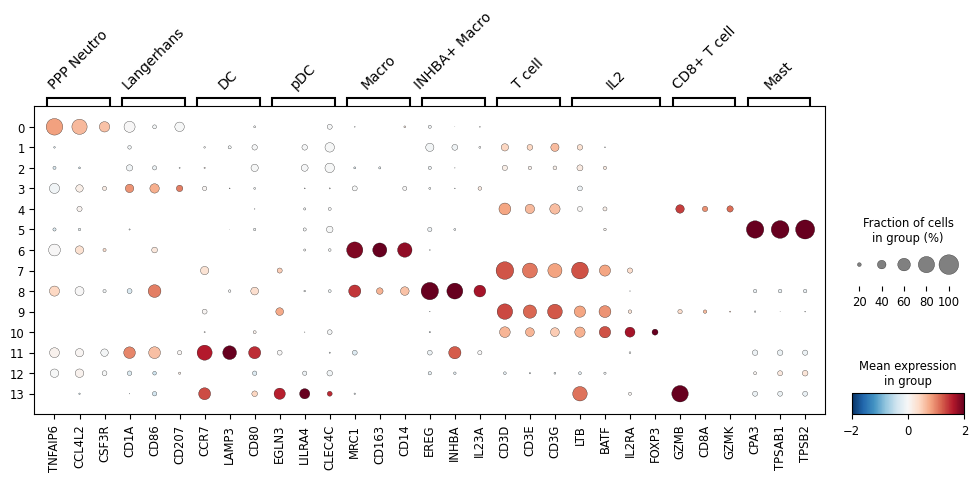

In [12]:
marker_gene = {'PPP Neutro': ['TNFAIP6', 'CCL4L2', 'CSF3R'],
                'Langerhans': ['CD1A', 'CD86', 'CD207'], # Langerhans cell
                'DC': ['CCR7', 'LAMP3', 'CD80',], # Dendritic cell
                'pDC': ['EGLN3', 'LILRA4', 'CLEC4C'],  # plasmacytoid dendritic cell 
               'Macro': ['MRC1', 'CD163', 'CD14'], # Macrophage 
               'INHBA+ Macro': ['EREG', 'INHBA', 'IL23A'],   # INHBA+ Macrophage
               'T cell': ['CD3D', 'CD3E', 'CD3G'], # CD3+ T cell
                'IL2': ['LTB', 'BATF', 'IL2RA', 'FOXP3'],
                # 'CD4 EMRA': ['PTPRC'], # CD4+ EMRA T cell
                'CD8+ T cell': ['GZMB', 'CD8A',  'GZMK'], #  CD8+ T cell
                # 'MT-CO1', 'MT-ATP6', 'MT-CYB', # Mito+ T cell
                'Mast': ["CPA3", "TPSAB1", "TPSB2"], # Mast cell
                # 'KLRD1', 'KLRF1', 'KLRB1'
}

with rc_context({'figure.figsize': (8, 7)}):
    ax = sc.pl.dotplot(adata_immu, marker_gene, groupby='leiden', show=False, use_raw=False, dot_max=1, dot_min=0.1, color_map='RdBu_r', vmax=2, vmin=-2, var_group_rotation=45, \
        figsize=(12, 4))

/home/wu/scanpy/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


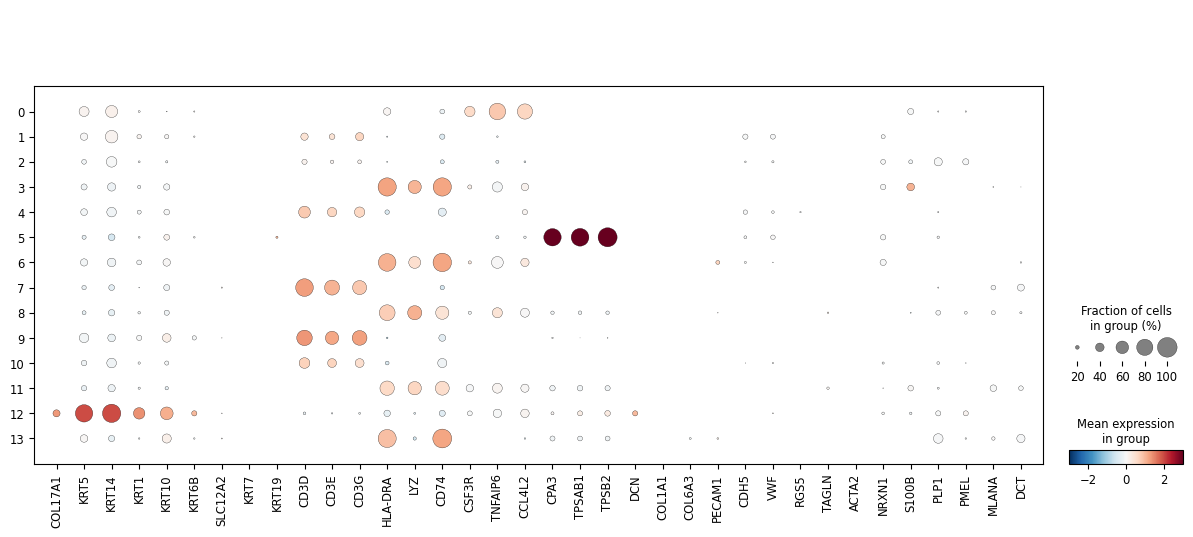

In [13]:
marker_genes = ["COL17A1", "KRT5", "KRT14", "KRT1", "KRT10", "KRT6B", "SLC12A2", "KRT7", "KRT19","CD3D","CD3E","CD3G",
                "HLA-DRA", "LYZ", "CD74", "CSF3R", "TNFAIP6","CCL4L2","CPA3","TPSAB1","TPSB2",
                "DCN","COL1A1","COL6A3","PECAM1","CDH5","VWF","RGS5","TAGLN","ACTA2",
                "NRXN1","S100B","PLP1","PMEL", "MLANA", "DCT"]

with rc_context({'figure.figsize': (8, 7)}):
    sc.pl.dotplot(adata_immu, marker_genes, groupby='leiden', show=False, use_raw=False, dot_max=1, dot_min=0.1, color_map='RdBu_r', vmax=3, vmin=-3)

/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


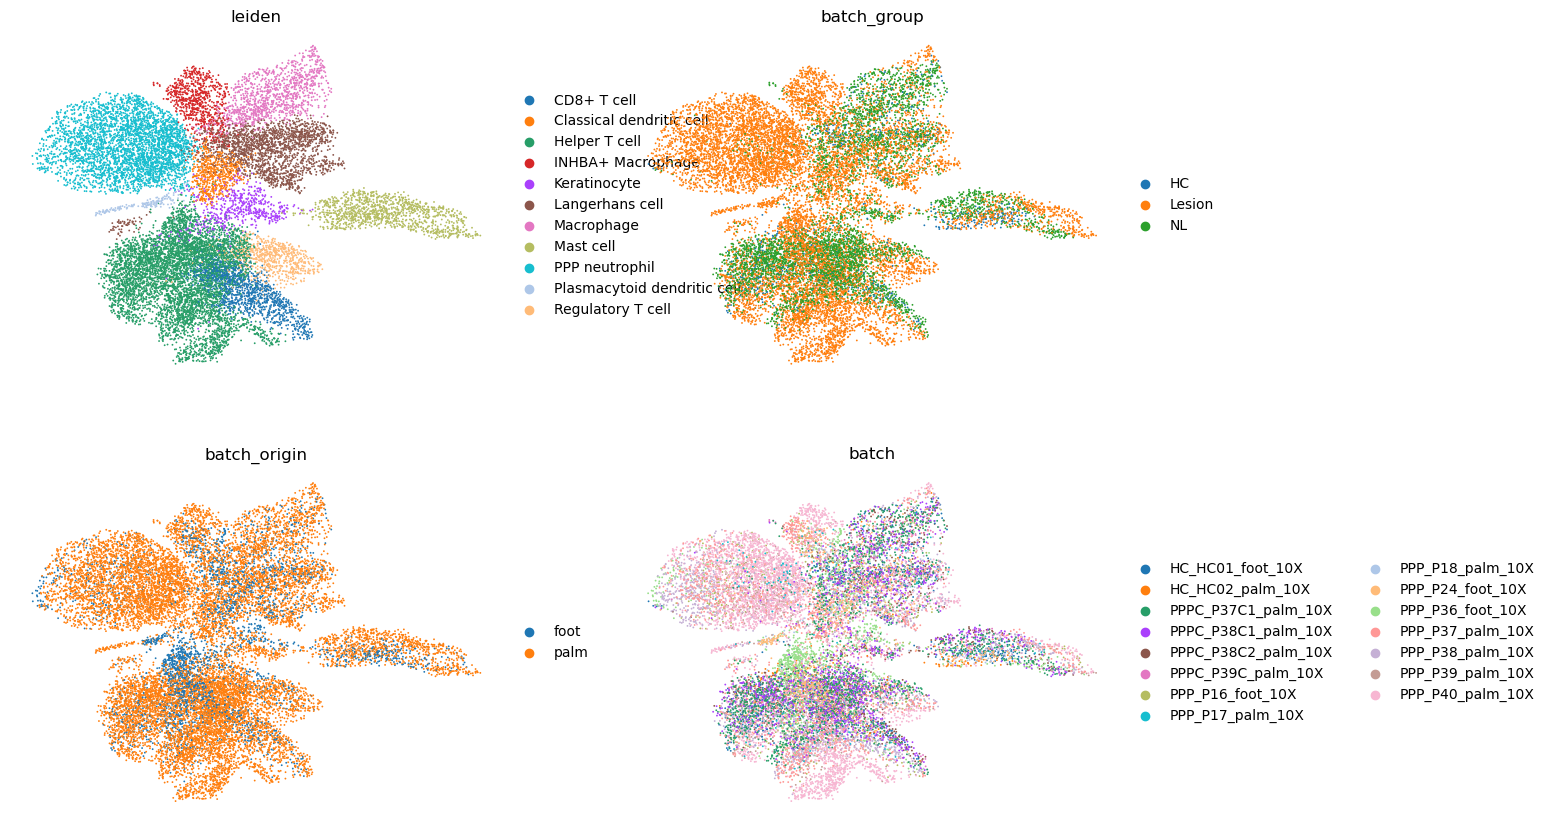

/home/wu/scanpy/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


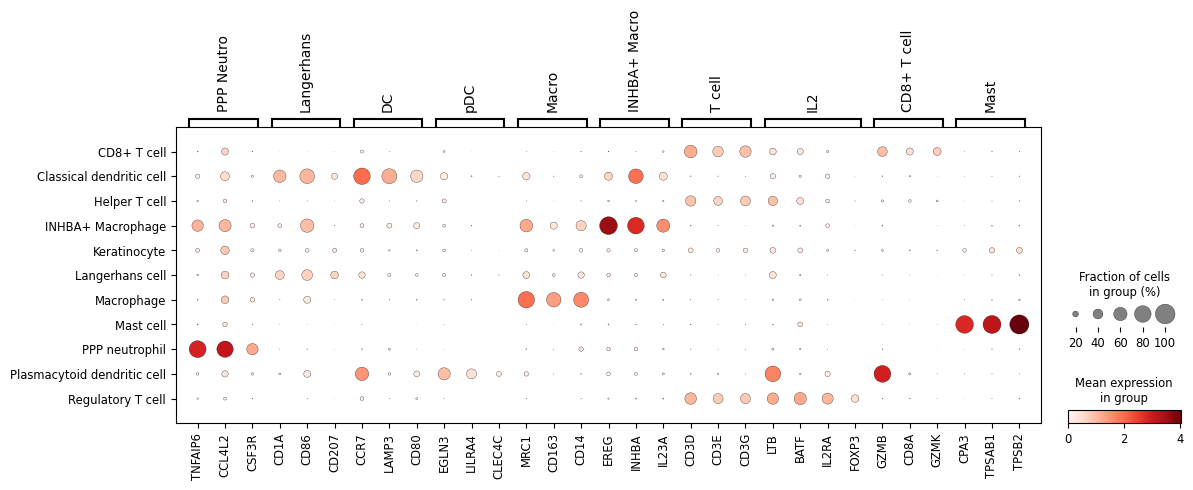

In [14]:
cluster_names = {
    '0': 'PPP neutrophil',
    '1': 'Helper T cell',
    '2': 'Helper T cell',
    '3': 'Langerhans cell',
    '4': 'CD8+ T cell',
    '5': 'Mast cell',
    '6': 'Macrophage',
    '7': 'Helper T cell',
    '8': 'INHBA+ Macrophage',
    '9': 'Helper T cell',
    '10': 'Regulatory T cell',
    '11': 'Classical dendritic cell',
    '12': 'Keratinocyte',
    '13': 'Plasmacytoid dendritic cell',
    # '14': 'Fibroblast',
}

adata_immu.obs['leiden'] = adata_immu.obs['leiden'].map(cluster_names).astype('category')
sc.pl.umap(adata_immu, color=['leiden', 'batch_group', 'batch_origin', 'batch'], ncols=2, frameon=False)
sc.pl.dotplot(adata_immu, marker_gene, groupby='leiden')

In [15]:
# filter possible technical mixed cells
# KRT5, KRT1, KRT16: keratinocyte
# "DCN","COL1A1","COL6A3": fibroblast
adata_immu = adata_immu[~adata_immu.obs['leiden'].isin(['Keratinocyte', 'Fibroblast'])].copy()

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


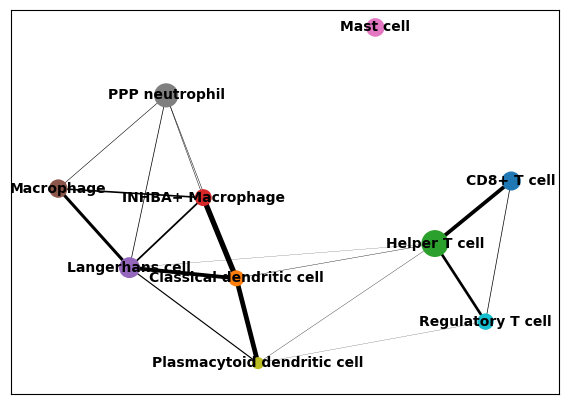

In [16]:
sc.tl.paga(adata_immu, groups='leiden')
sc.pl.paga(adata_immu)

# sc.tl.umap(adata_immu, init_pos='paga', min_dist=0.5, spread=0.5)
# sc.pl.umap(adata_immu, color=['leiden'], frameon=False, size=10, alpha=0.8)

In [17]:
adata_immu.write_h5ad('processed_data/IMMU_PPP_10X.h5ad')